How to print weight for convLSTM?

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
from ConvLSTM_pytorch import convlstm
import operator
from utils_v4 import *

# Load Data

In [2]:
#selected subset of dates. 
val_dates = ['180409','180412','180414']
test_dates = ['180411', '180413']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/'
model_saving_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models'





## Load data helper functions

In [3]:
def create_files_new(load_path, bad_dates, T_length=10, proceed=1): 
    sleep_files = os.listdir(load_path+'sleep/')
    move_files = os.listdir(load_path+'move/')
    all_files = sleep_files+move_files
    
    dic = {}
    for f in all_files:
        mvmt_type = f.split('_')[-1].split('.')[0]
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        time = float(f.split('_')[3][4:])
        if date in bad_dates:
            continue
        if mvmt_type == 'sleep':
            label = 1
        else:
            label = 0
        if date in dic:
            if rec in dic[date]:
                dic[date][rec].append([f, label, mvmt_type, date, rec, time])
            else:
                dic[date][rec] = [[f, label, mvmt_type, date, rec, time]]
        else:
            dic[date] = {rec: [[f, label, mvmt_type, date, rec, time]]}
        
    for d in dic:
        for r in dic[d]:
            dic[d][r] = sorted(dic[d][r], key=operator.itemgetter(3, 4, 5))
    
    move_data, sleep_data = [], []
    for d in dic:
        for r in dic[d]:
            sleep_grouped, move_grouped = create_files_new_helper(dic[d][r], T_length=T_length, proceed=proceed)
            sleep_data.append(sleep_grouped)
            move_data.append(move_grouped)
    
    return move_data, sleep_data

In [4]:
def create_files_new_helper(L, T_length, proceed):
    L_labels = np.array([L[i][1] for i in range(len(L))])
    L_times = np.array([L[i][-1] for i in range(len(L))])
    
    L_new_sleep, L_new_move = [], []
    start = 0
    while start <= len(L)-T_length:
        end = start + T_length
        #pdb.pm()
        if sum(L_times[start+1:end]-L_times[start:end-1]-time_window) != 0:
            start += 1
            continue
        if sum(L_labels[start:end]) == T_length:
            L_new_sleep.append(L[start:end])
        elif sum(L_labels[start:end]) == 0:
            L_new_move.append(L[start:end])
        start += proceed
    return L_new_sleep, L_new_move

In [5]:
def upsample(train_files):
    train_sleep = [i for i in train_files if i[0][1] == 1]
    train_move = [i for i in train_files if i[0][1] == 0]
    diff = abs(len(train_sleep)-len(train_move))
    train_new = []
    d = 0
    while d < diff:
        if len(train_sleep) > len(train_move):
            ind = random.randint(0, len(train_move)-1)
            x = train_move[ind]
            d += 1
        else:
            ind = random.randint(0, len(train_sleep)-1)
            x = train_sleep[ind]
            d += 1
        train_new.append(x)   
    train_files = train_sleep+train_move+train_new
    return train_files

In [6]:
class SpectrogramDatasetAtt(Dataset):
    def __init__(self, files, load_path, T_length, all_label=False, CH=None):
        self.CH = CH
        self.files = files
        self.load_path = load_path
        self.T_length = T_length
        self.all_label = all_label
  
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        group = self.files[idx]
        specs, labels, dates, recs, times = [], [], [], [], []
        for i in range(len(group)):
            f, label, mvmt_type, date, rec, time = group[i]
            spec = torch.from_numpy(np.load(self.load_path+mvmt_type+'/'+f))
            if self.CH is not None:
                spec = torch.transpose(spec[self.CH,:,:].unsqueeze(0), 2, 1)
            else:
                spec = torch.transpose(spec, 2, 1)
            specs.append(spec)
            labels.append(torch.Tensor([label]))
            dates.append(date)
            recs.append(rec)
            times.append(time)
            if i == (self.T_length-1)/2:
                label_mid = torch.Tensor([label])
                date_mid = date
                rec_mid = rec
                time_mid = time
        if self.all_label:
            return specs, labels, dates, recs, times
        else:
            return specs, label_mid, date_mid, rec_mid, time_mid

## T-length = 3

In [7]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [8]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [9]:
## Upsample train
train_files = upsample(train_files)

In [10]:
len(train_files), len(val_files), len(test_files)

(13420, 1916, 1715)

In [11]:
## Load files to dataloader

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

## convLSTM

In [12]:
## Define Model
class convLSTM(nn.Module):
    def __init__(self, input_dim = 1, layers = 1, hidden_dim = 10, frequencies = 100,timewindow = 10, output_size=1, batch_size=128):
        super(convLSTM, self).__init__()
        
        self.input_dim = input_dim
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = layers
        self.hidden_dim = hidden_dim
        self.freqs = frequencies
        self.timewindow = timewindow
        
        # Define the lstm layer
        self.convLSTM = convlstm.ConvLSTM(input_dim=self.input_dim,
                 hidden_dim=self.hidden_dim,
                 kernel_size=(3, 3),
                 num_layers=self.n_layers,
                 batch_first=False,
                 bias=True,
                 return_all_layers=False)
        # Define the fully-connected layer
#         self.fc = nn.Linear(self.n_layers*self.hidden_dim, output_size)
        self.fc = nn.Linear(self.hidden_dim*self.freqs*self.timewindow, output_size)

    def forward(self, input_seq):
        
        # convLSTM
        _, last_states = self.convLSTM(input_seq)
        last_states = last_states[0][0]
        last_states = last_states.reshape(last_states.shape[0], -1)
        fc = self.fc(last_states)        

        return fc

### Training functions

In [13]:
def get_accuracy(model, loader, device='cuda', collect_result = False):
    """
    Function that calculate the accuracy of the model. 
    """
    correct = 0
    total = 0
    pred, labs = [],[]
    with torch.no_grad():
        for data, labels, _, _, _ in loader:
            # Labels
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            # Data
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            # Feed data to model
            outputs = model(data)            
            outputs = torch.tensor(outputs).to(device)
            # Predictions
            predictions = (outputs > 0.5) * 1.0
            predictions = predictions.flatten().detach().cpu().numpy()
            labels = labels.flatten().cpu().numpy()
            # Calculate Accuracy
            total += len(labels)
            correct += (predictions == labels).sum()
            
            if collect_result:
                pred.append(predictions)
                labs.append(labels)
            
    accuracy = correct / total
    if collect_result:
        return accuracy, pred, labs
    return accuracy

In [14]:
def train(model, optimizer, criterion, loader, device='cuda'):
    """
    Function that train the model. 
    """
    model.train()
    epoch_losses = 0
    epoch_lens = 0
    parameter_history = []
    # criterion = nn.BCELoss()
    for batch_idx, (data, labels, _, _, _) in enumerate(loader):
        # Get Label
        labels = torch.stack(labels)
        labels = labels[0]
        labels = torch.flatten(labels).to(device).float()
        labels = labels.to(device).float()
#         print(batch_idx)
        
        # Get data
        data = torch.tensor(np.stack(data)).to(device).float() 
        data = data.to(device).float()

        # Zero out grad
        optimizer.zero_grad()

        # Data in model
        outputs = model(data)
#         outputs = torch.tensor(outputs,requires_grad = True).to(device)
        outputs = torch.squeeze(outputs)

        # Get loss
        loss = criterion(torch.sigmoid(outputs), labels)
#         print(loss)
        epoch_losses += loss
        epoch_lens += 1

        parameter_history.append(list(model.parameters())[0])
        loss.backward() # error?
        optimizer.step()

    epoch_accs = get_accuracy(model, loader, device=device, collect_result = False)
    return epoch_losses/epoch_lens, epoch_accs, parameter_history

def evaluate(model, optimizer, criterion, loader, device='cuda', collect_result = False):
    model.eval()
    epoch_losses = 0
    epoch_lens = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, _, _, _) in enumerate(loader):
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            labels = torch.flatten(labels).to(device).float()
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            outputs = model(data)
#             outputs = torch.tensor(outputs).to(device)
            outputs = torch.squeeze(outputs)
            loss = criterion(torch.sigmoid(outputs), labels)
            epoch_losses += loss
            epoch_lens += 1
    
    if collect_result:
        epoch_accs, pred, labs = get_accuracy(model, loader, device = device, collect_result = True)
        return epoch_losses/epoch_lens,epoch_accs, pred, labs
    else:
        epoch_accs = get_accuracy(model, loader, device=device, collect_result = collect_result)
    return epoch_losses/epoch_lens, epoch_accs

### Training

In [16]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
tlength = 3
# verbose = False


model = convLSTM(input_dim = 62).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.10496535152196884
Val loss for epoch 0: 0.16686028242111206
1
Train loss for epoch 1: 0.0784769281744957
Val loss for epoch 1: 0.15996871888637543
Train loss for epoch 2: 0.04006227105855942
Val loss for epoch 2: 0.18249201774597168
Train loss for epoch 3: 0.021307112649083138
Val loss for epoch 3: 0.17629961669445038
Train loss for epoch 4: 0.016199497506022453
Val loss for epoch 4: 0.200855553150177
Train loss for epoch 5: 0.009423335082828999
Val loss for epoch 5: 0.28711777925491333
Train loss for epoch 6: 0.005252160131931305
Val loss for epoch 6: 0.2669503092765808
Train loss for epoch 7: 0.0036682768259197474
Val loss for epoch 7: 0.28015315532684326
Train loss for epoch 8: 0.0027442611753940582
Val loss for epoch 8: 0.26035434007644653
Train loss for epoch 9: 0.0017559974221512675
Val loss for epoch 9: 0.2950598895549774
Train loss for epoch 10: 0.001332779647782445
Val loss for epoch 10: 0.3582456707954407
Train loss for epoch 11: 0.0011065385770052

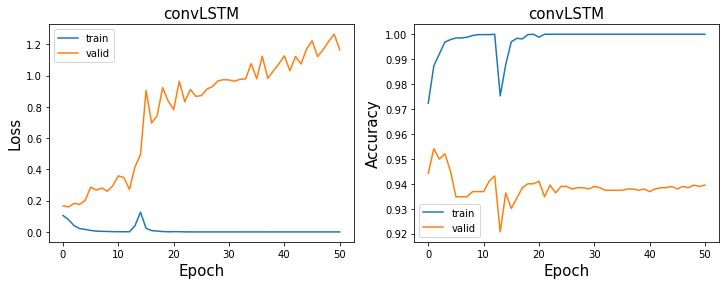

In [18]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, tlength,epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [19]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, tlength)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH3_trainresult.pt


In [20]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

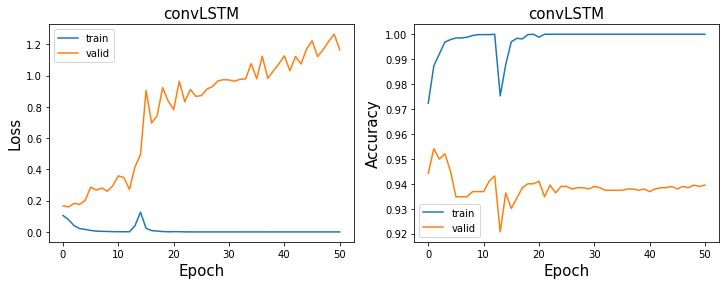

In [21]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [22]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          1


/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH3_EPOCH1.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.15996871888637543 accuracy:0.954070981210856
/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH3_valcm.pt


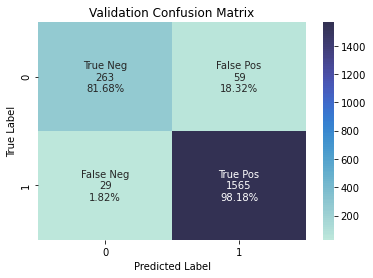

In [24]:
T_length = 3
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    


## T-length = 5

In [25]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [26]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [27]:
## Upsample train
train_files = upsample(train_files)

In [28]:
len(train_files), len(val_files), len(test_files)

(13420, 1916, 1715)

In [29]:
## Load files to dataloader
T_length = 5

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [30]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
# verbose = False


model = convLSTM(input_dim = 62).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.8277043700218201
Val loss for epoch 0: 0.2957892119884491
1
Train loss for epoch 1: 0.12063498049974442
Val loss for epoch 1: 0.2498476654291153
Train loss for epoch 2: 0.06620609015226364
Val loss for epoch 2: 0.2697792649269104
Train loss for epoch 3: 0.04037094861268997
Val loss for epoch 3: 0.3360711634159088
Train loss for epoch 4: 0.024118635803461075
Val loss for epoch 4: 0.38129153847694397
Train loss for epoch 5: 0.014990543946623802
Val loss for epoch 5: 0.41912025213241577
Train loss for epoch 6: 0.007626852486282587
Val loss for epoch 6: 0.41660863161087036
Train loss for epoch 7: 0.007700806949287653
Val loss for epoch 7: 0.5418325066566467
Train loss for epoch 8: 0.0033901510760188103
Val loss for epoch 8: 0.5454444885253906
Train loss for epoch 9: 0.001967074815183878
Val loss for epoch 9: 0.4690770208835602
Train loss for epoch 10: 0.001267878571525216
Val loss for epoch 10: 0.618567705154419
Train loss for epoch 11: 0.0009596023010089993
Val

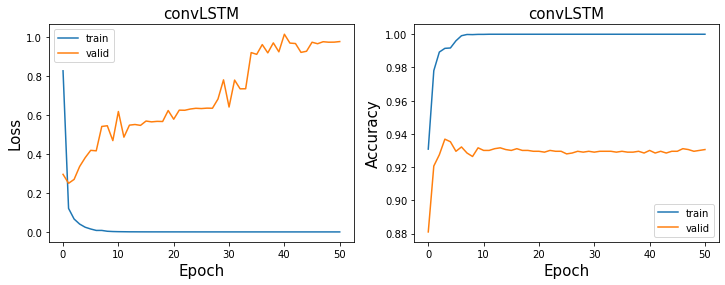

In [31]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [32]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_trainresult.pt


In [33]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

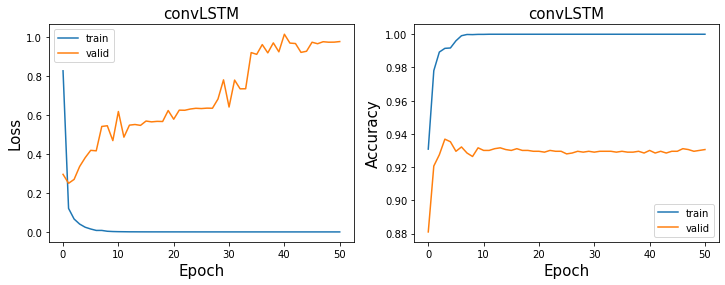

In [34]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [35]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
tlength = 'TLENGTH'+str(T_length)
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s and tlength in s and 'valcm' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          1


/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_EPOCH1.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.2498476654291153 accuracy:0.9206680584551148
/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_valcm.pt


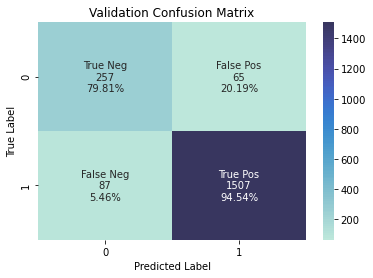

In [36]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    


## T-length = 10

In [37]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [38]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [39]:
## Upsample train
train_files = upsample(train_files)

In [40]:
len(train_files), len(val_files), len(test_files)

(13420, 1916, 1715)

In [41]:
## Load files to dataloader
T_length = 10

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [42]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
# verbose = False


model = convLSTM(input_dim = 62).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.6595047116279602
Val loss for epoch 0: 0.29397717118263245
1
Train loss for epoch 1: 0.20630545914173126
Val loss for epoch 1: 0.2118079513311386
Train loss for epoch 2: 0.10689122974872589
Val loss for epoch 2: 0.29935869574546814
Train loss for epoch 3: 0.07623035460710526
Val loss for epoch 3: 0.45945990085601807
Train loss for epoch 4: 0.04141548275947571
Val loss for epoch 4: 0.30983710289001465
Train loss for epoch 5: 0.08927543461322784
Val loss for epoch 5: 0.4730668067932129
Train loss for epoch 6: 0.04413643106818199
Val loss for epoch 6: 1.113507866859436
Train loss for epoch 7: 0.02463441528379917
Val loss for epoch 7: 1.337969183921814
Train loss for epoch 8: 0.015291674062609673
Val loss for epoch 8: 1.198746919631958
Train loss for epoch 9: 0.01881829835474491
Val loss for epoch 9: 0.9643669724464417
Train loss for epoch 10: 0.017083309590816498
Val loss for epoch 10: 0.9998220205307007
Train loss for epoch 11: 0.012651536613702774
Val loss fo

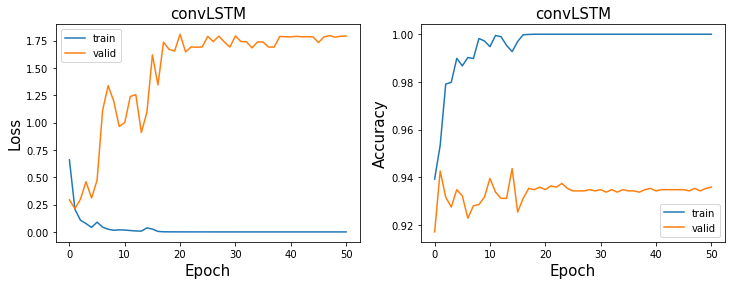

In [43]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [44]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_trainresult.pt


In [45]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

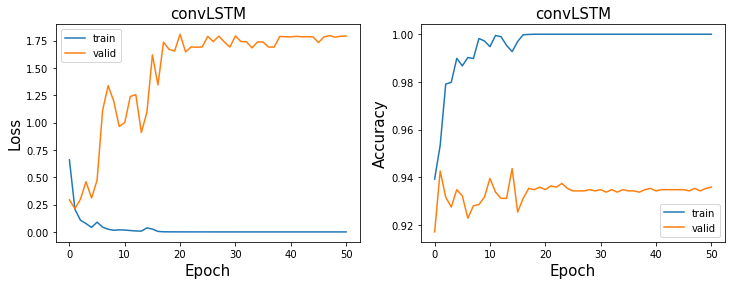

In [46]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [47]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
tlength = 'TLENGTH'+str(T_length)
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s and tlength in s and 'valcm' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          1


/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_EPOCH1.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.2118079513311386 accuracy:0.94258872651357
/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_valcm.pt


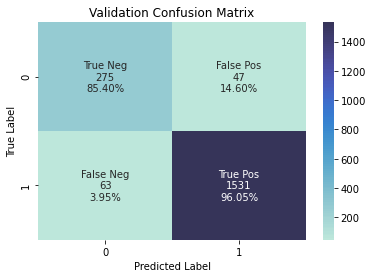

In [48]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    
